# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we will try to help you better understand the problem and therefore propose a good solution for this coursework. You will learn 

* how to load and save data of `h5` format
* what is a k-space data and how to recontruct a image from it
* how to generate random masks, undersampled k-space and undersampled images
* how to compute a SSIM for a pair of 3D volumes

In [1]:
%matplotlib inline

import h5py, os
import numpy as np
from matplotlib import pyplot as plt

## Training data set
The MRI dataset we used for this coursework is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from training dataset. Each file corresponds to one MRI scan volume (many stacked slices), containing the corresponding k-space data and some meta data related to the scan. Let's first look at examples from the training data set. We loop through all training data to see what each HD5 file contains: each file has a key denoted by `'kspace'`.

In [2]:
file_path = '/data/local/NC2019MRI/train/'

for fname in sorted(os.listdir(file_path)): 
    subject_path = os.path.join(file_path, fname)
    with h5py.File(subject_path,  "a") as hf:
        print(f'file {fname} key is {list(hf.keys())}')

OSError: Unable to create file (unable to open file: name = '/data/local/NC2019MRI/train/file1000000.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [4]:
file_path = '/data/local/NC2019MRI/train/file1000000.h5'

with h5py.File(file_path,  "r") as hf:
    volume_kspace = hf['kspace'][()]
    print(volume_kspace.shape)
    print(volume_kspace.dtype)

(35, 640, 368)
complex64


In MRI raw data, k-space is complex-valued and has the following shape: (number of slices, height, width). 

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

Let's see what the absolute value of k-space looks like. In the following, we will show the kspace data at Slice 5, 10, 20 and 30. 

In [5]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

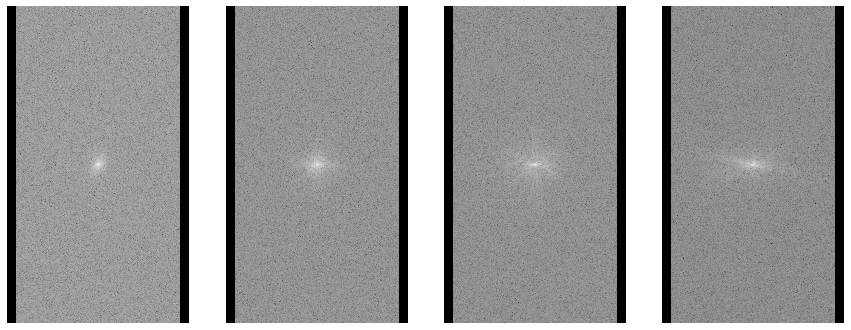

In [6]:
show_slices(np.log(np.abs(volume_kspace) + 1e-9), [5, 10, 20, 30], cmap='gray')  # This shows slices 0, 5 and 10

We now provide some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors. First, we need import some existing external functions from `data` and `common` directories 

In [7]:
from functions import transforms as T

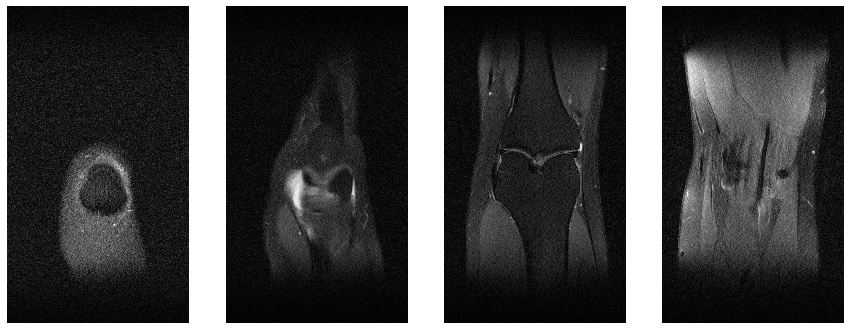

In [8]:
volume_kspace2 = T.to_tensor(volume_kspace)      # Convert from numpy array to pytorch tensor
volume_image = T.ifft2(volume_kspace2)            # Apply Inverse Fourier Transform to get the complex image
volume_image_abs = T.complex_abs(volume_image)   # Compute absolute value to get a real image

show_slices(volume_image_abs, [5, 10, 20, 30], cmap='gray') # Original images without undersampling 

The relation between a k-space data and its image form is a inverse Fourier transform, the implementation of which has been given in `transforms.py` under `data` folder. As k-space data is complex-valued its corresponding image is also complex-valued. As such, to visualise the image we need to compute the absolute value (known as magnitude). We note that in the Kaggle challenge we will evaluate the performance using the ground truth magnitude image. 

show_slices(volume_image_abs, [5, 10, 20, 30], cmap='gray')

Above images were inverted from the original k-space data, which are fully sampled. We can simulate under-sampled data by creating a mask and applying it to k-space. Below we show you how to so. 

In [ ]:
import torch
from functions.subsample import MaskFunc

mask_func0 = MaskFunc(center_fractions=[0.08], accelerations=[4])  # Create the mask function object
mask_func1 = MaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

Above we created two mask function objects. The first one defines a mask with 4 times acceleration rate (AF) and the second one defines a mask object with 8 times acceleration rate. When the acceleration factor equals 4, the fully-sampled central region includes 4% of all k-space lines. The remaining k-space lines are included uniformly at random, with the probability set so that, on average, the undersampling mask achieves the desired acceleration factor. This ensures that the expected number of k-space selected is equal to (N / acceleration), where N is number of columns. 

As a thumb rule, the bigger acceleration rate (ie. more aggressive subsampling), the faster speed we can get to scan a patient. But as a result, the recontruction with bigger acceleration rate normal leads to poor image quality. That comes to the meaning of this coursework. Simply speaking, we would like you to propose a machine/deep learning method that is able to recontruct high quality images using large acceleration rates. The successful development of such a method will increase patient throughput and reduce problems with patient comfort and compliance as well as high exam costs.

In [ ]:
shape = np.array(volume_kspace2.shape)

mask0 = mask_func0(shape, seed=0) # use seed here to exclude randomness  
mask1 = mask_func1(shape, seed=0)

masked_kspace0 = torch.where(mask0 == 0, torch.Tensor([0]), volume_kspace2) # masked kspace data with AF=4
masked_kspace1 = torch.where(mask1 == 0, torch.Tensor([0]), volume_kspace2) # masked kspace data with AF=8

S_Num, Ny, Nx, _ = volume_kspace2.shape
masks0 = mask0.repeat(S_Num, Ny, 1, 1).squeeze() # masks when AF=4
masks1 = mask1.repeat(S_Num, Ny, 1, 1).squeeze() # masks when AF=8


show_slices(masks0, [5, 10, 20, 30], cmap='gray')  # visualise masks (AF=4)
show_slices(torch.log(T.complex_abs(masked_kspace0) + 1e-9), [5, 10, 20, 30], cmap='gray') # visualise masked kspace (AF=4)

show_slices(masks1, [5, 10, 20, 30], cmap='gray')  # visualise masks (AF=8)
show_slices(torch.log(T.complex_abs(masked_kspace1) + 1e-9), [5, 10, 20, 30], cmap='gray') # visualise masked kspace (AF=8)


Above, the first row shows the masks generated when AF=4 and the second row shows the masked (undersampled) kspace data (ie. point-wise mulitplication between the original kspace data and the masks). The third row and fourth row show the cases when AF=8.

Let's see what the subsampled image looks like:

In [ ]:
sampled_image0 = T.ifft2(masked_kspace0)             # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs0 = T.complex_abs(sampled_image0)   # Compute absolute value to get a real image

sampled_image1 = T.ifft2(masked_kspace1)             # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs1 = T.complex_abs(sampled_image1)   # Compute absolute value to get a real image

show_slices(volume_image_abs, [5, 10, 20, 30], cmap='gray') # Original images without undersampling 
show_slices(sampled_image_abs0, [5, 10, 20, 30], cmap='gray') # Images with undersampling rate 4 
show_slices(sampled_image_abs1, [5, 10, 20, 30], cmap='gray') # Images with undersampling rate 8 

As can be seen above, as the AF goes higher, the images after inverse Fourier transform becomes blurred. Bear in mind however that the kspace data producing images in the last row can be very quickly acquired from a scanner. The speed is 8 times faster than acquiring the fully sampled kspace data producing the images in the first row. 

The question for you now is: how can you get sharp images using an aggressive undersampling rate ?

In [ ]:
# crop the images to the central 320x320 pixel region, as evaluation will be made based on cropped images
cropped_gt = T.center_crop(volume_image_abs, [320, 320])
cropped_4af = T.center_crop(sampled_image_abs0, [320, 320])
cropped_8af = T.center_crop(sampled_image_abs1, [320, 320]) 


show_slices(cropped_gt, [5, 10, 20, 30], cmap='gray') # cropped Original images without undersampling 
show_slices(cropped_4af, [5, 10, 20, 30], cmap='gray') # cropped images with undersampling rate 4 
show_slices(cropped_8af, [5, 10, 20, 30], cmap='gray') # cropped images with undersampling rate 8 

## SSIM
We can evaluate SSIM on the whole volume in the region of interset (320x320 central region) with respect to ground truth. As can be seen, the more aggressive sampling we have, the lower SSIM value we get. 

In [ ]:
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [ ]:
print(ssim(cropped_gt.numpy(), cropped_4af.numpy()))
print(ssim(cropped_gt.numpy(), cropped_8af.numpy()))

## Save .h5 data
The following code is created for you to save your reconstruction results in order to submit and compare with the ground truth images we hold.

In [ ]:
def save_reconstructions(reconstructions, out_dir):
    """
    Saves the reconstructions from a model into h5 files that is appropriate for submission
    to the leaderboard.
    Args:
        reconstructions (dict[str, np.array]): A dictionary mapping input filenames to
            corresponding reconstructions (of shape num_slices x height x width).
        out_dir (pathlib.Path): Path to the output directory where the reconstructions
            should be saved.
    """
    for fname, recons in reconstructions.items():
        subject_path = os.path.join(out_dir, fname)
        print(subject_path)
        with h5py.File(subject_path, 'w') as f:
            f.create_dataset('reconstruction', data=recons)

In [ ]:
# Note that you should save your recontruction as the same name as the input file name. 
# For example if you recontruct file1000000.h5 you should save your reconstruction result as file1000000.h5 but in a different directory
# The following is an example about how to save mulitple files at once. 

fname0 = 'file1000000.h5'
fname1 = 'file1000001.h5'
fname2 = 'file1000002.h5'
reconstructions = {fname0: cropped_gt.numpy(), fname1: cropped_4af.numpy(), fname2: cropped_8af.numpy()}
out_dir = '../saved/' # where you want to save your result. 
if not (os.path.exists(out_dir)): os.makedirs(out_dir)
save_reconstructions(reconstructions, out_dir)


## Now, let's look at examples from the test data set

In [ ]:
file_path = 'data/local/test/'

for fname in sorted(os.listdir(file_path)):
    subject_path = os.path.join(file_path, fname)
    with h5py.File(subject_path,  "r") as hf:
        print(f'file {fname} key is {list(hf.keys())}')

In [ ]:
file_path = 'data/local/test/file1000817.h5'

with h5py.File(file_path,  "r") as hf:
    volume_kspace_4af = hf['kspace_4af'][()]
    volume_kspace_8af = hf['kspace_8af'][()]
    mask_4af = hf['mask_4af'][()]
    mask_8af = hf['mask_8af'][()]
    print(volume_kspace_4af.shape)
    print(volume_kspace_4af.dtype)
    print(mask_4af.shape)
    print(mask_4af.dtype)

For the test set, each data contains a 4-fold undersampled k-space data and a 4-fold mask that generates the undersampled k-space. The 8-fold undersampled k-space data and the 8-fold mask were also included. You may want to use the masks provided to develop more advanced learning methods. Note that for the test set, we hold the fully sampled k-space data, where we can easily compute the ground truth images. `Your mission is to see how accurate your method can reconstruct an image from the corresponding undersampled k-space for both undersampled rates, by comparing your reconstruction with the ground truth we hold`.

In [ ]:
data = np.array([mask_4af, mask_8af])
show_slices(data, [0, 1], cmap='gray')  # This shows masks when AF=4 and AF=8, respectively

In [ ]:
show_slices(np.log(np.abs(volume_kspace_4af) + 1e-9), [5, 10, 20, 30], cmap='gray')  # This shows slices 0, 5 and 10
show_slices(np.log(np.abs(volume_kspace_8af) + 1e-9), [5, 10, 20, 30], cmap='gray')  # This shows slices 0, 5 and 10

In [ ]:
volume_kspace2 = T.to_tensor(volume_kspace_4af)      # Convert from numpy array to pytorch tensor
volume_image = T.ifft2(volume_kspace2)            # Apply Inverse Fourier Transform to get the complex image
volume_image_abs_4af = T.complex_abs(volume_image)   # Compute absolute value to get a real image
show_slices(volume_image_abs_4af, [5, 10, 20, 30], cmap='gray') # Reconstructed images with undersampling rate 4

volume_kspace2 = T.to_tensor(volume_kspace_8af)      # Convert from numpy array to pytorch tensor
volume_image = T.ifft2(volume_kspace2)            # Apply Inverse Fourier Transform to get the complex image
volume_image_abs_8af = T.complex_abs(volume_image)   # Compute absolute value to get a real image
show_slices(volume_image_abs_8af, [5, 10, 20, 30], cmap='gray') # Reconstructed images with undersampling rate 8

In [ ]:
# crop the images to the central 320x320 pixel region, as evaluation will be made based on cropped images
show_slices(T.center_crop(volume_image_abs_4af, [320, 320]), [5, 10, 20, 30], cmap='gray') # cropped images with undersampling rate 4 
show_slices(T.center_crop(volume_image_abs_8af, [320, 320]), [5, 10, 20, 30], cmap='gray') # cropped images with undersampling rate 8 